# How to generate synthetic papyrus volumes

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from synthetic_pages.datasets.synthetic_datamodule_cubes import SyntheticInstanceCubesDataset

Use reference volume and labels (see [this link](https://dl.ash2txt.org/community-uploads/tim/dec_2024_submission_data/pretraining_reference/) for an example reference volume/label pair) to seed synthetic papyrus dataset:

In [ ]:
dataset = SyntheticInstanceCubesDataset(
    "../../vast-scrolls/reference_volume.nrrd", 
    "../../vast-scrolls/reference_labels.nrrd")
batch = next(iter(dataset))

In [28]:
import math
from typing import Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap


def _to_numpy(array_3d: torch.Tensor | np.ndarray) -> Tuple[np.ndarray, bool]:
    """Return (numpy_array, was_torch)."""
    if isinstance(array_3d, torch.Tensor):
        if array_3d.requires_grad:
            array_3d = array_3d.detach()
        array_3d = array_3d.cpu()
        return array_3d.numpy(), True
    return array_3d, False


def _even_indices(total: int, n: int) -> np.ndarray:
    """Evenly spaced integer indices in [0, total-1] of length ≤ n."""
    return np.arange(total) if n >= total else np.linspace(0, total - 1, n, dtype=int)


def _make_label_colormap(max_label: int) -> ListedColormap:
    """Black for 0, diverse colours for 1..max_label."""
    black = np.array([[0, 0, 0, 1.0]])           # RGBA
    if max_label <= 20:
        colours = plt.cm.tab20(np.linspace(0, 1, max(1, max_label)))  # 20 distinct hues
    else:                                         # stich together several qualitative maps
        stacks: Iterable[np.ndarray] = (
            plt.cm.tab20(np.linspace(0, 1, 20)),
            plt.cm.tab20b(np.linspace(0, 1, 20)),
            plt.cm.tab20c(np.linspace(0, 1, 20)),
            plt.cm.Paired(np.linspace(0, 1, 12)),
            plt.cm.Set3(np.linspace(0, 1, 12)),
        )
        colours = np.vstack(stacks)[: max_label]
    return ListedColormap(np.vstack([black, colours]))


def visualize_3d_array_samples(
    array_3d: torch.Tensor | np.ndarray,
    slice_axis: int = 0,
    num_samples: int = 20,
    figsize: Tuple[int, int] = (15, 12),
) -> plt.Figure:
    """
    Show evenly spaced slices from a 3-D volume.

    * **Float dtype**  → grayscale             (continuous intensity)
    * **Integer dtype** → categorical colour map (label map)
    """
    vol_np, is_torch = _to_numpy(array_3d)
    is_float = np.issubdtype(vol_np.dtype, np.floating)

    total_slices = vol_np.shape[slice_axis]
    slice_indices = _even_indices(total_slices, num_samples)

    # ---------- figure scaffold -------------------------------------------------
    plt.style.use("dark_background")
    grid_dim = math.ceil(math.sqrt(len(slice_indices)))
    fig = plt.figure(figsize=figsize, facecolor="black")
    grid = fig.add_gridspec(grid_dim, grid_dim, hspace=0.3, wspace=0.3)
    axes = [fig.add_subplot(grid[i, j], facecolor="black")
            for i in range(grid_dim)
            for j in range(grid_dim)]

    # ---------- colour mapping --------------------------------------------------
    if is_float:
        cmap = "gray"
        vmin, vmax = float(vol_np.min()), float(vol_np.max())
    else:
        vmax = int(vol_np.max())
        cmap = _make_label_colormap(vmax)

    # ---------- render each requested slice -------------------------------------
    axis_name = "XYZ"[slice_axis]
    for ax_idx, slice_idx in enumerate(slice_indices):
        ax = axes[ax_idx]
        if slice_axis == 0:
            slice_2d = vol_np[slice_idx, :, :]
        elif slice_axis == 1:
            slice_2d = vol_np[:, slice_idx, :]
        else:
            slice_2d = vol_np[:, :, slice_idx]

        im = ax.imshow(slice_2d, cmap=cmap, vmin=0 if not is_float else vmin, vmax=vmax)
        ax.set_title(f"{axis_name}-slice {slice_idx}", color="white", fontsize=9)
        ax.set_xticks([]); ax.set_yticks([])

    for ax in axes[len(slice_indices):]:
        ax.axis("off")

    # ---------- colour-bar -------------------------------------------------------
    cbar = fig.colorbar(im, ax=axes, shrink=0.8, pad=0.01)
    if not is_float:                                         # label-map ticks
        if vmax <= 20:
            ticks = np.arange(0, vmax + 1) + 0.5
            cbar.set_ticks(ticks)
            cbar.set_ticklabels(range(vmax + 1))
        else:
            step = max(1, vmax // 10)
            ticks = np.arange(0, vmax + 1, step)
            cbar.set_ticks(ticks + 0.5)
            cbar.set_ticklabels(ticks)
        cbar.set_label("label", color="white")
    else:
        cbar.set_label("intensity", color="white")
    cbar.ax.yaxis.set_tick_params(color="white")
    cbar.outline.set_edgecolor("white")
    plt.setp(cbar.ax.get_yticklabels(), color="white")

    # ---------- super-title ------------------------------------------------------
    tensor_type = "Torch" if is_torch else "NumPy"
    mode = "grayscale (float)" if is_float else "label map (int)"
    fig.suptitle(
        f"{len(slice_indices)} slices along {axis_name} • {tensor_type} • {mode}",
        color="white", fontsize=14
    )
    fig.set_constrained_layout(True)
    return fig


## Volume visualisation

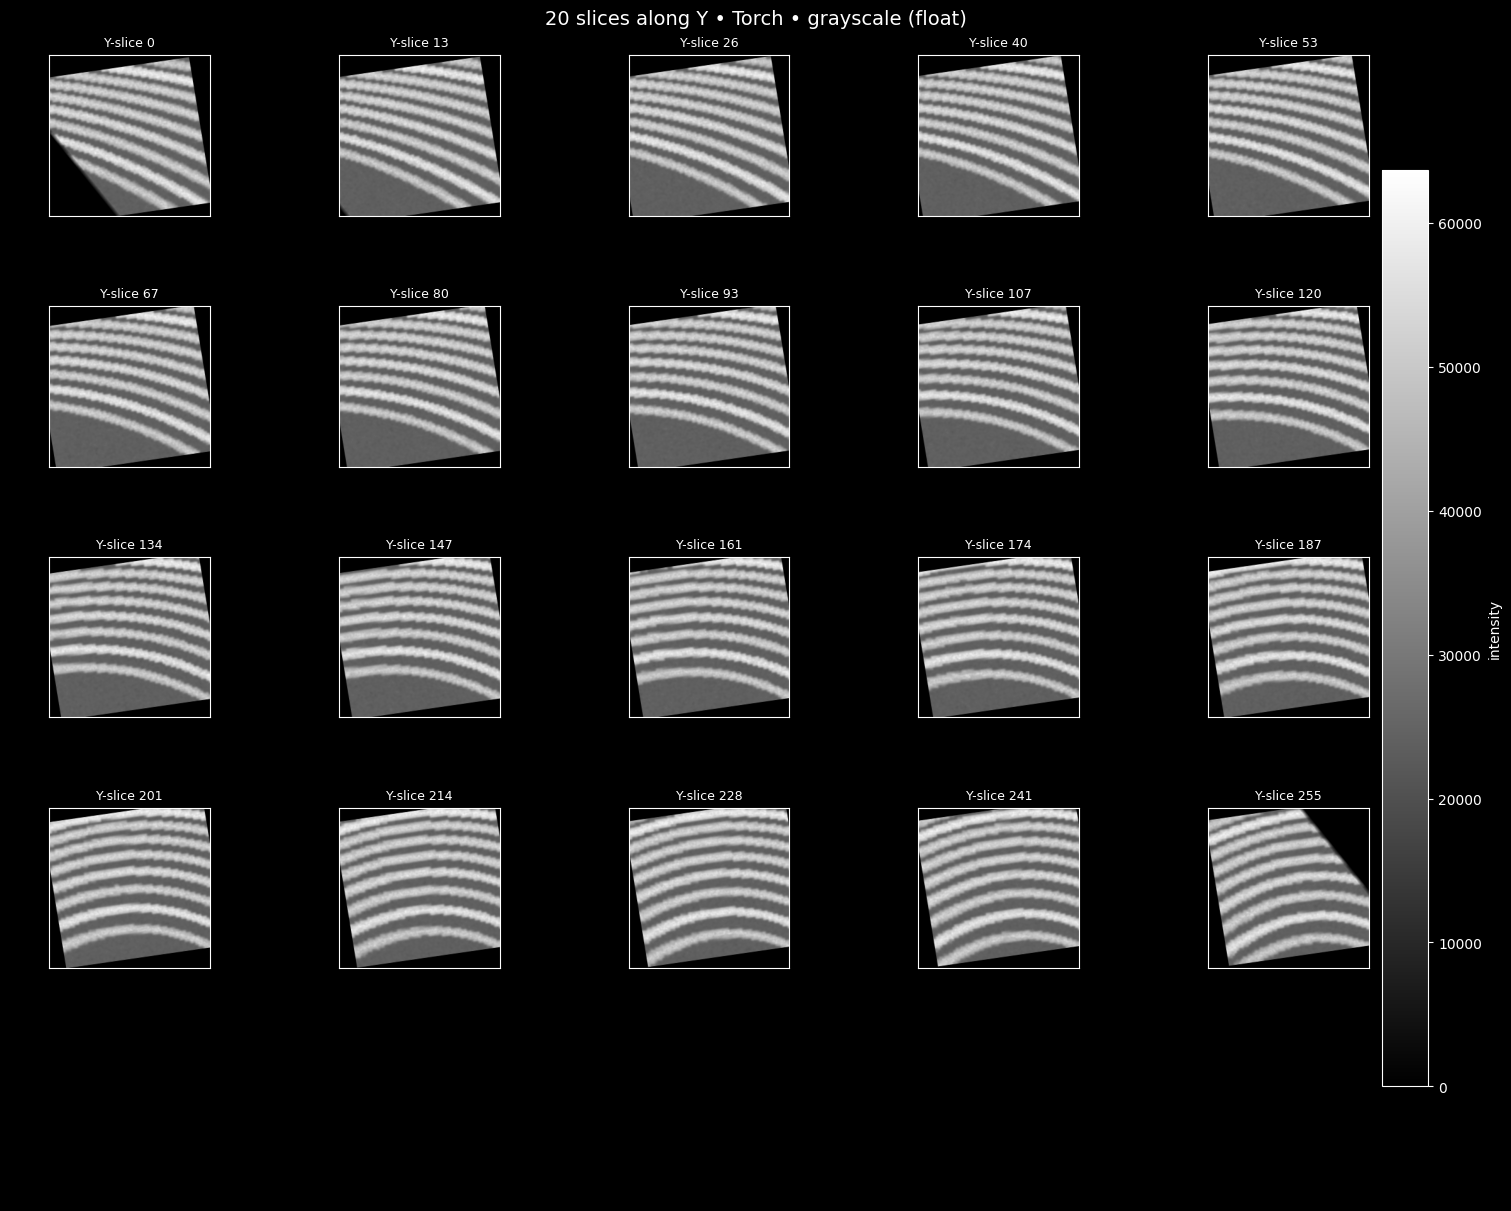

In [31]:
visualize_3d_array_samples(batch["vol"], slice_axis=1)
plt.show()

## Labelmap visualisation

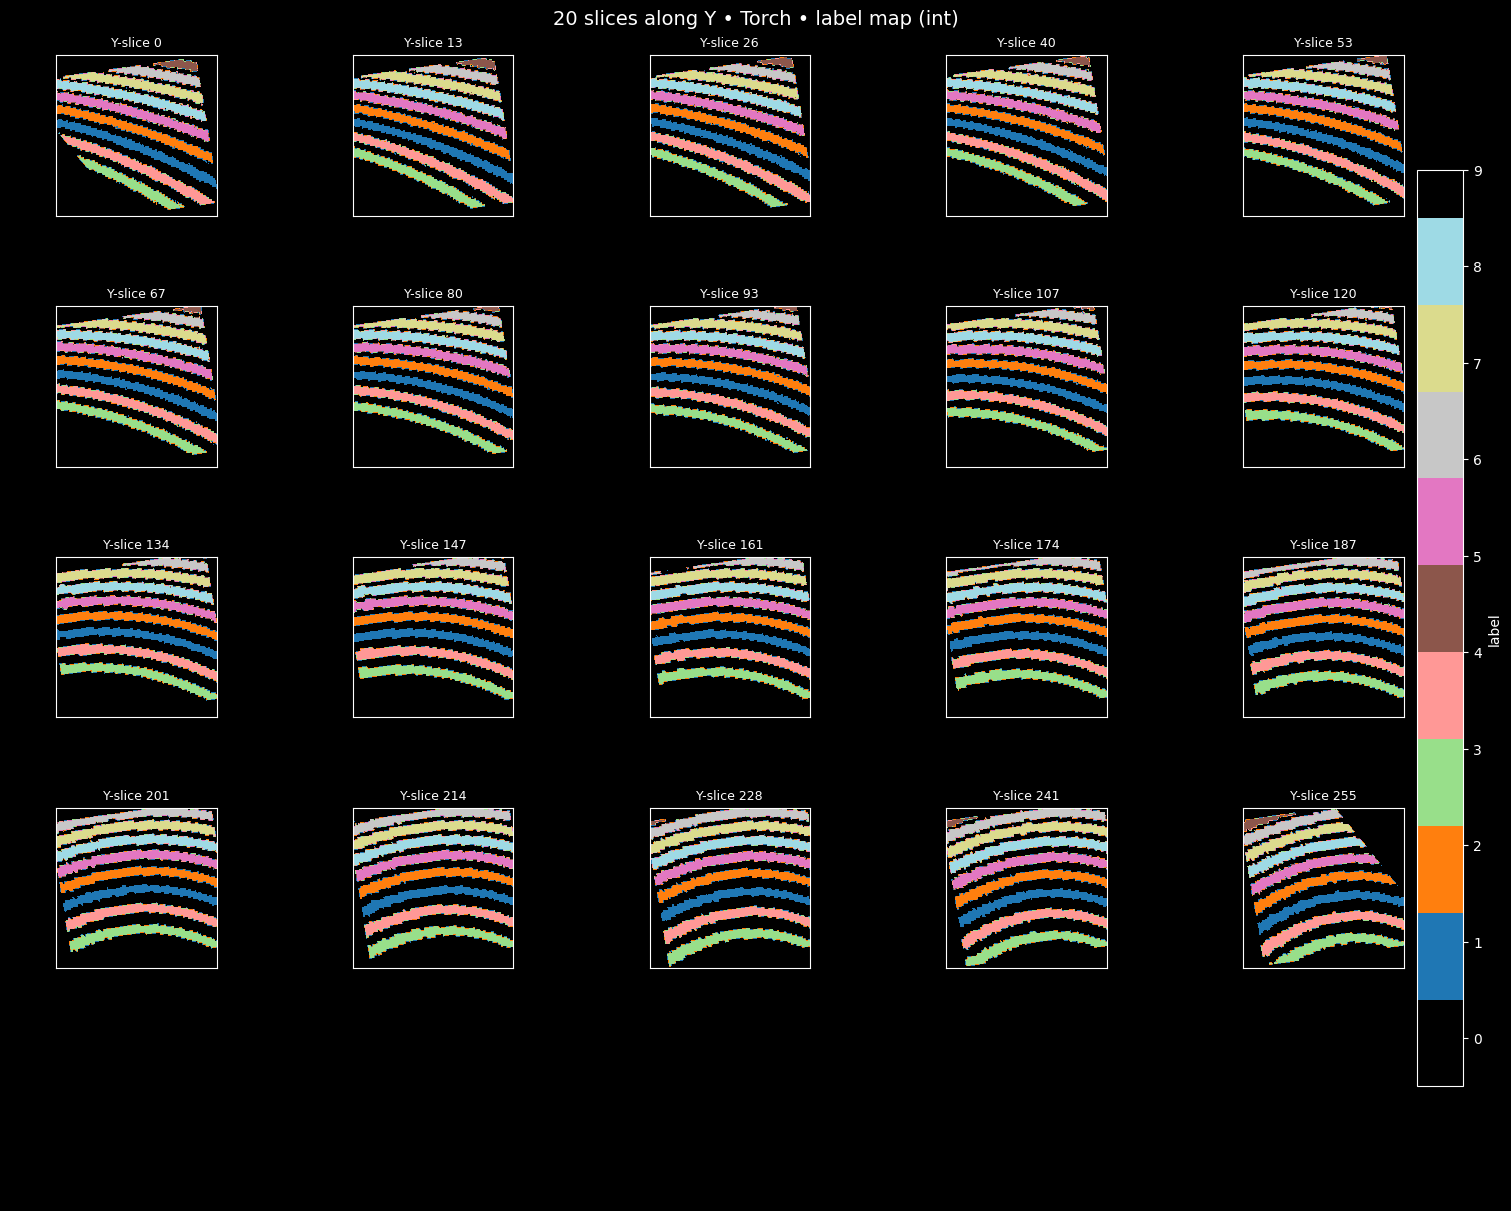

In [29]:
visualize_3d_array_samples(batch['lbl'].argmax(dim=0), slice_axis=1)
plt.show()